**TASK 3**: MITRAL VALVE SEGMENTATION

TASK 3: MITRAL VALVE SEGMENTATION
The mitral valve is the largest valve of the heart and regulates the blood flow between the left atrium and the left ventricle. It is composed by two leaflets, the anterior and the posterior leaflet, that are attached to a fibrous ring known as the mitral annulus. In healthy patients, the left atrium contracts during diastole and the blood flows through the open MV into the left ventricle while it is dilating.
Echocardiography is a medical imaging technique that produces 2D pictures and videos of the heart using ultrasound waves generated by a transducer, scattered and reflected by biological tissues and read by a detector. Echocardiography is the standard imaging tool in the clinical routine to perform the diagnosis of most of heart diseases and dysfunctions, including MV diseases.
Mitral valve segmentation specifies a crucial first step to establish a machine learning pipeline that can support practitioners in performing multiple tasks including the diagnosis of mitral valve diseases, surgical planning, and intraoperative procedures. Therefore, this task will be concerned with the segmentation of the mitral valve in echocardiography videos.

The training set consists of 65 videos in which the mitral valve is labled in three different frames in each video. Additionllay, a bounding box surounding the mitral valve is provided for each video. The test set consists of 20 videos. For each video in the test set the mitral valve should be segmented for all frames.

In [ ]:
#@title Installs
# !pip install numpy
# !pip install gzip
# !pip install pickle
# !pip install cv2

In [ ]:
#@title Imports
import numpy as np
import gzip
import pickle
import cv2


# np.set_printoptions(threshold=np.inf)


import matplotlib.pyplot as plt
import matplotlib.animation as animation

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.layers import Bidirectional, LSTM, Reshape, ReLU, BatchNormalization, Flatten, Embedding, SimpleRNN, GRU, Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate, Add, Conv1D, concatenate, Conv2D, Conv2DTranspose, Dropout, Input, MaxPool2D, Reshape
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Activation, LeakyReLU, Softmax, Reshape
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical

In [ ]:
#@title Mount Drive

use_drive = True
if use_drive:
  PATH = "drive/My Drive/AML_HS22/task3/"
  from google.colab import drive
  drive.mount('/content/drive')
else:
  PATH = "./"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Load Data

def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

def save_zipped_pickle(obj, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, 2)

def load_data():
  train_data = load_zipped_pickle(PATH + "train.pkl")
  test_data = load_zipped_pickle(PATH + "test.pkl")

  print("Train length %s" %str(len(train_data)))
  print("Test length %s" %str(len(test_data)))
  return train_data, test_data
  
train_data, test_data = load_data()
#samples = load_zipped_pickle(PATH + "sample.pkl")
#X_imp, y, X_test_imp = load_data()

Train length 65
Test length 20


In [ ]:
#@title Display Data

def blend_rgba(front, back):
  frontRGB = front[...,:3]
  backRGB = back[...,:3]

  frontA = front[...,3]/255.0
  backA = back[...,3]/255.0
  outA = frontA + backA*(1-frontA)
  outRGB = (frontRGB*frontA[...,np.newaxis] + backRGB*backA[...,np.newaxis]*(1-frontA[...,np.newaxis])) / outA[...,np.newaxis]
  outRGBA = np.dstack((outRGB,outA*255)).astype(np.uint8)
  return outRGBA

def add_markings(video, frames = None, markings = None, mark_color = (200, 50, 50, 200)):
  video = np.asarray(video)
  video_out = []
  if frames is None:
    frames = range(len(video))
  
  for i in range(len(video)):
    frame_rgba = video[i]
    if len(frame_rgba.shape) == 2:
      frame_rgba = cv2.cvtColor(frame_rgba,cv2.COLOR_GRAY2RGBA)

    if i not in frames:
        video_out.append(frame_rgba)
        continue

    if not markings is None:
      markings = np.asarray(markings)
      mark = markings[i] if len(markings.shape)==3 else markings
      mark_rgba = np.zeros(shape=(mark.shape[0],mark.shape[1], 4), dtype=np.uint8)
      mark_rgba[mark==True]=mark_color
      frame_rgba = blend_rgba(mark_rgba, frame_rgba)
    
    #frame_3_channel[mask==True]=(255, 255, 0)
    video_out.append(frame_rgba)
  return video_out

def save_video(video, name):
  fig = plt.figure()
  plt.axis('off')
  img = plt.imshow(video[0])
  def update(i):
    img.set_array(video[i])
    return img,

  ani = animation.FuncAnimation(fig, update, frames=len(video))
  ani.save(PATH+f'{name}.avi', writer="ffmpeg", fps=15)

# def plot_video(video, frames=None):
#   if frames is None:
#     frames = range(len(video))
#   for i in frames:
#     frame = video[i]
#     shw = plt.imshow(frame)
#     bar = plt.colorbar(shw)
#     plt.show()

def plot_first_xcount_frame_of_video(video, xcount=3, name=None):
  if name is not None:
    print(f"Begin {name}:")
  frame_number = min(len(video), xcount)
  for i in range(frame_number):
    frame = video[i]
    print(frame)
    shw = plt.imshow(frame)
    bar = plt.colorbar(shw)
    plt.show()
  print(f"End {name}.")

# Prepare Training Data

In [ ]:
#@title Dataset Modification
def resize(input_image, input_mask):
   input_image = cv2.resize(input_image, (128, 128), interpolation=cv2.INTER_NEAREST)
   input_mask = cv2.resize(input_mask, (128, 128), interpolation=cv2.INTER_NEAREST)
   return input_image, input_mask

def augment(input_image, input_mask):
  # TODO: add random crop
  # TODO: add perspective transform (as we resize different aspect ratios)
  if np.random.uniform(0,1) > 0.5:
    # Random flipping of the image and mask
    input_image = cv2.flip(input_image, 1)
    input_mask = cv2.flip(input_mask, 1)
  return input_image, input_mask

def normalize(input_image, input_mask):
   input_image = input_image.astype(np.float32) / 255.0
  #  input_mask -= 1
   return input_image, input_mask

def transform_image_train(image, label):
  input_image, input_label = resize(image, label)
  #  input_image, input_mask = augment(input_image, input_mask)
  input_image, input_label = normalize(input_image, input_label)
  return input_image, input_label

def transform_image_test(image):
  input_image, _ = resize(image, image)
  input_image, _ = normalize(input_image, input_image)
  return input_image


In [ ]:
#@title Bounding Box functions
# import math
# class Point:
#   def __init__(self, x,y):
#     self.x, self.y = x,y

#   def rotate(self, angle=0, o=None):
#     """
#     Rotate a point counterclockwise by a given angle around a given origin.

#     The angle should be given in degrees.
#     """
#     angle = math.radians(angle)
#     if o is None:
#       o = Point(0, 0)
#     new_x = o.x + math.cos(angle) * (self.x - o.x) - math.sin(angle) * (self.y - o.y)
#     new_y = o.y + math.sin(angle) * (self.x - o.x) + math.cos(angle) * (self.y - o.y)
#     return Point(round(new_x), round(new_y))
  
#   def __repr__(self):
#     return f"({self.x},{self.y})"

# class Box:

#   def __init__(self, top=None, bottom=None, mask=None, shape=None):
#     self.top = top
#     self.bottom = bottom
#     self.mask = mask
#     if shape is None:
#       self.shape = mask.shape if mask is not None else None
#     else:
#       self.shape=shape
#     self.get_coordinates()
import math
def rotate_point(point, angle=0, origin=None):
    angle = math.radians(angle)
    x,y = point
    ox,oy = (0, 0) if origin is None else origin
    new_x = ox + math.cos(angle) * (x - ox) - math.sin(angle) * (y - oy)
    new_y = oy + math.sin(angle) * (x - ox) + math.cos(angle) * (y - oy)
    return round(new_x), round(new_y)
  
def rotate_box(box, shape, angle=0, origin=None):
  ox,oy = origin
  x1,y1,x2,y2 = box
  r1x,r1y = rotate_point((x1,y1), angle, origin)
  r2x,r2y = rotate_point((x1,y2), angle, origin)
  r3x,r3y = rotate_point((x2,y2), angle, origin)
  r4x,r4y = rotate_point((x2,y1), angle, origin)
  #print([r1.x,r2.x,r3.x,r4.x])
  
  min_x = max(0, np.min([r1x,r2x,r3x,r4x]))
  min_y = max(0, np.min([r1y,r2y,r3y,r4y]))
  max_x = min(shape[1], np.max([r1x,r2x,r3x,r4x]))
  max_y = min(shape[0], np.max([r1y,r2y,r3y,r4y]))

  return min_x, min_y, max_x, max_y

def crop_to_box(label, box):
  x1,y1,x2,y2 = box
  #cropped_image = image[y1:y2+1, x1:x2+1]
  cropped_label = label[y1:y2+1, x1:x2+1]
  return cropped_label

#   def crop(self, q1, q2):
#     p1 = Point(max(self.top.x, q1.x), \
#                max(self.top.y, q1.y))
#     p2 = Point(min(self.top.x, q1.x), \
#                min(self.top.y, q1.y))
#     shape = (p2.y-p1.y, p2.x-p1.x)
#     return Box(top=p1, bottom=p2, shape=shape)

def get_coordinates(mask):
  # if (self.top,self.bottom) != (None, None):
  #   return self.top,self.bottom
  where = np.array(np.where(mask))
  y1,x1 = np.amin(where, axis=1)
  # self.top = Point(coord_top[1], coord_top[0])
  y2,x2 = np.amax(where, axis=1)
  # self.bottom = Point(coord_bottom[1], coord_bottom[0])
  return (x1,y1,x2,y2)

def normalize_box(box, shape):
  return np.array(list(map(lambda a,b: a/b, box, (shape[1], shape[0], shape[1], shape[0]))))

def convert_back_box(box, shape):
  return np.array(list(map(lambda a,b: int(a*b), box, (shape[1], shape[0], shape[1], shape[0]))))

def insert_into_bounding_box(label, box, shape):
  x1,y1,x2,y2 = box
  label = cv2.resize(label, (x2-x1, y2-y1), interpolation=cv2.INTER_NEAREST)
  out = np.zeros(shape)
  out[y1:y2,x1:x2] = label
  return out

def mean_box(boxes):
  x1 = np.min(boxes[:, 0])
  y1 = np.min(boxes[:, 1])
  x2 = np.max(boxes[:, 2])
  y2 = np.max(boxes[:, 3])
  return (x1, y1, x2, y2)

  # def get_mask(self):
  #   if self.mask is not None:
  #     return self.mask
  #   self.mask = np.zeros(self.shape)
  #   self.mask[self.top.y:self.bottom.y+1, self.top.x:self.bottom.x+1] = 1
  #   return self.mask
  
  # def __repr__(self):
  #   return f"Box: {self.top} - {self.bottom}"





In [ ]:
#@title get Label training data 
def rotate_data(image, label, box, angle):
  (h, w) = image.shape
  (cX, cY) = (w // 2, h // 2)
  rot_mat = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
  image_out = cv2.warpAffine(image, rot_mat, (w, h))
  label_out = cv2.warpAffine(label, rot_mat, (w, h))
  box_out = rotate_box(box, image_out.shape, angle=-angle, origin=(cX, cY))
  return image_out, label_out, box_out

def get_label_training_data(data):
  images, labels, boxes, full, shapes = [], [], [], [], []
  for i in range(len(data)):
    org_entry = data[i]

    for j, f in enumerate(org_entry['frames']):
      image_org = org_entry['video'][:,:,f]
      label_org = org_entry['label'][:,:,f].astype(np.uint8)
      box_org = get_coordinates(org_entry['box'])
      # if j == 0:
      #   print(org_entry['video'][:,:,f].shape)
      
      for angle in range(-45, 46, 10):
        image, label, box = rotate_data(image_org, label_org, box_org, angle)
        shape = image.shape
        shapes.append(shape)
        temp, _ = resize(image, image)
        temp, _ = normalize(temp, temp)
        full.append(cv2.cvtColor(temp,cv2.COLOR_GRAY2RGB))
        boxes.append(normalize_box(box, shape))
        
        #image, label = crop_to_box(image, label, box)
        image, label = resize(image, label)
        image, label = normalize(image, label)
        #image, label = transform_image_train(image, label)
        images.append(image)
        labels.append(label)
        # for crop in crops:
        #   image, label = crop_data(image, label, angle)
        # if i == 0 and j == 0:
        #   #label = insert_into_bounding_box(np.ones((10,10)), box, image.shape)
        #   # print(label)
        #   # plt.figure()
        #   f, axarr = plt.subplots(1,2) 
        #   shw_img = axarr[0].imshow(image)
        #   shw_lbl = axarr[1].imshow(label)
        #   plt.colorbar(shw_img, ax=axarr[0])
        #   plt.colorbar(shw_lbl, ax=axarr[1])
        #   plt.show()
  return np.asarray(images), np.asarray(labels), np.asarray(boxes), np.asarray(full), np.asarray(shapes)

In [ ]:
#@title get Box training data
def get_box_training_data(data):
  images, boxes, shapes = [], [], []
  for i in range(len(data)):
    org_entry = data[i]
    for f in range(0, org_entry['video'].shape[-1]):
      image = org_entry['video'][:,:,f]
      shape = image.shape[:2]
      image, _= resize(image, image)
      image, _= normalize(image, image)
      image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
      # image, _ = transform_image_train(image, image)
      # label_org = org_entry['label'][:,:,f].astype(np.uint8)
      box_org = get_coordinates(org_entry['box'])
      box = normalize_box(box_org, shape)
      images.append(image)
      boxes.append(box)
      shapes.append(shape)
  return np.asarray(images), np.asarray(boxes), np.asarray(shapes) 

In [ ]:
#@title prepare all data
X_train_boxes, train_boxes, X_train_shapes = get_box_training_data(train_data)
print(f'X_train_boxes.shape: {X_train_boxes.shape}')
print(f'train_boxes.shape: {train_boxes.shape}')
print(f'X_train_shapes.shape: {X_train_shapes.shape}')

X_train_labels, train_labels, train_boxes_2, X_train_boxes_2, X_train_shapes_2 = get_label_training_data(train_data)
print(f'X_train_labels.shape: {X_train_labels.shape}')
print(f'train_labels.shape: {train_labels.shape}')

X_train_boxes = np.concatenate([X_train_boxes, X_train_boxes_2])
train_boxes = np.concatenate([train_boxes, train_boxes_2])
X_train_shapes = np.concatenate([X_train_shapes, X_train_shapes_2])
print(f'X_train_boxes.shape: {X_train_boxes.shape}')
print(f'train_boxes.shape: {train_boxes.shape}')
print(f'X_train_shapes.shape: {X_train_shapes.shape}')

# center data
data_mean = np.mean(X_train_boxes)
data_std = np.std(X_train_boxes)
X_train_boxes -= data_mean
X_train_boxes /= data_std

X_train_labels -= data_mean
X_train_labels /= data_std

# test_dataset = np.array(list(map(load_image_test, testing_data)))

X_train_boxes.shape: (9869, 128, 128, 3)
train_boxes.shape: (9869, 4)
X_train_shapes.shape: (9869, 2)
X_train_labels.shape: (1950, 128, 128)
train_labels.shape: (1950, 128, 128)
X_train_boxes.shape: (11819, 128, 128, 3)
train_boxes.shape: (11819, 4)
X_train_shapes.shape: (11819, 2)


# Train Models

In [ ]:
#@title Bounding Box Regression
def bbr_model():
  vgg = VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(128, 128, 3)))
  # freeze all VGG layers so they will *not* be updated during the
  # training process
  vgg.trainable = False
  # flatten the max-pooling output of VGG
  flatten = vgg.output
  flatten = Flatten()(flatten)
  # construct a fully-connected layer header to output the predicted
  # bounding box coordinates
  bboxHead = Dense(128, activation="relu")(flatten)
  bboxHead = Dense(64, activation="relu")(bboxHead)
  bboxHead = Dense(32, activation="relu")(bboxHead)
  bboxHead = Dense(4, activation="sigmoid")(bboxHead)
  # construct the model we will fine-tune for bounding box regression
  model = Model(inputs=vgg.input, outputs=bboxHead)
  return model

In [ ]:
#@title Bounding Box Regression - train model

bbr_model = bbr_model()
bbr_model.compile(loss="mse", optimizer=Adam(learning_rate=1e-4))
#print(model.summary())
# train the network for bounding box regression
early = EarlyStopping(monitor="val_loss", mode="min", patience=2, verbose=1)

print("[INFO] training bounding box regressor...")
H = bbr_model.fit(
	X_train_boxes, train_boxes,
  validation_split=0.1,
	epochs=15,
	callbacks=[early],
	batch_size = 32,
	verbose=1)

[INFO] training bounding box regressor...
Epoch 1/15
333/333 [==============================] - 32s 68ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 2/15
333/333 [==============================] - 20s 60ms/step - loss: 3.4117e-04 - val_loss: 0.0026
Epoch 3/15
333/333 [==============================] - 20s 59ms/step - loss: 2.0196e-04 - val_loss: 0.0028
Epoch 4/15
333/333 [==============================] - 20s 59ms/step - loss: 1.5169e-04 - val_loss: 0.0026
Epoch 4: early stopping


In [ ]:
#@title U-Net Building Blocks
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = MaxPool2D(2)(f)
   p = Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = concatenate([x, conv_features])
   # dropout
   x = Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

def build_unet_model():
  # inputs
   inputs = Input(shape=(128,128))
   reshape = Reshape(target_shape=(128,128, 1))(inputs)
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(reshape, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)
   # outputs
   outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(u9)
   # unet model with Keras Functional API
   unet_model = Model(inputs, outputs, name="U-Net")
   return unet_model

In [ ]:
#@title Loss function U-Net 
class DiceLoss(tf.keras.losses.Loss): # from https://dev.to/_aadidev/3-common-loss-functions-for-image-segmentation-545o
    def __init__(self, smooth=1e-6, gama=2):
        super(DiceLoss, self).__init__()
        self.name = 'NDL'
        self.smooth = smooth
        self.gama = gama

    def call(self, y_true, y_pred):
        y_true, y_pred = tf.cast(y_true, dtype=tf.float32), tf.squeeze(tf.cast(y_pred, tf.float32))
        # print(f"y_true: {y_true}")
        # print(f"y_pred: {y_pred}")
        nominator = 2 * tf.reduce_sum(tf.multiply(y_pred, y_true)) + self.smooth
        denominator = tf.reduce_sum(
            y_pred ** self.gama) + tf.reduce_sum(y_true ** self.gama) + self.smooth
        result = 1 - tf.divide(nominator, denominator)

        # intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
        # sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
        # jac = (intersection + self.smooth) / (sum_ - intersection + self.smooth)
        # return (1 - jac) * self.smooth

        return result

class TverskyLoss(tf.keras.losses.Loss): # from https://lars76.github.io/2018/09/27/loss-functions-for-segmentation.html
    def __init__(self, beta=0.5):
        super(TverskyLoss, self).__init__()
        self.name = 'Tversky'
        self.beta = beta

    def call(self, y_true, y_pred):
        y_true, y_pred = tf.cast(y_true, dtype=tf.float32), tf.squeeze(tf.cast(y_pred, tf.float32))
        # print(f"y_true: {y_true}")
        # print(f"y_pred: {y_pred}")
        # nominator = 2 * tf.reduce_sum(tf.multiply(y_pred, y_true)) + self.smooth
        # denominator = tf.reduce_sum(
        #     y_pred ** self.gama) + tf.reduce_sum(y_true ** self.gama) + self.smooth
        # result = 1 - tf.divide(nominator, denominator)

        numerator = y_true * y_pred
        denominator = y_true * y_pred + self.beta * (1 - y_true) * y_pred + (1 - self.beta) * y_true * (1 - y_pred)

        return 1 - tf.reduce_sum(numerator) / tf.reduce_sum(denominator)

In [ ]:
#@title Compile U-Net Model
unet_model = build_unet_model()
unet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=DiceLoss(smooth=1e-3, gama=2),
    metrics=[tf.keras.metrics.BinaryIoU()]
)
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128)]   0           []                               
                                                                                                  
 reshape (Reshape)              (None, 128, 128, 1)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['reshape[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']             

In [ ]:
#@title fit U-Net Model
# model_history = unet_model.fit(train_dataset[:,0], train_dataset[:,1], epochs=15)

MODEL_NAME = "U-Net"
MODEL_PATH = PATH + f"models/{MODEL_NAME}.h5"

class EvaluateCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_dataset):
        super().__init__()
        self.test_dataset = test_dataset

    def on_epoch_end(self, epoch, logs=None):
        for i, img_dict in enumerate(self.test_dataset):
          predicted_frames = unet_model.predict(img_dict["frames"])

          f, axarr = plt.subplots(1,2) 
          shw_img = axarr[0].imshow(img_dict["frames"][0])
          shw_lbl = axarr[1].imshow(predicted_frames[0][:,:,0])
          plt.colorbar(shw_img, ax=axarr[0])
          plt.colorbar(shw_lbl, ax=axarr[1])
          plt.show()
          break

checkpoint = ModelCheckpoint(MODEL_PATH, monitor='val_binary_io_u', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_binary_io_u", mode="max", patience=2, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_binary_io_u", mode="max", patience=1, verbose=2)
#eval = EvaluateCallback(X_test)
tensorboard = TensorBoard(log_dir=PATH + f"logs/{MODEL_NAME}")
callbacks_list = [
    checkpoint,
    early,
    redonplat,
    tensorboard,
#    eval,
    ]

unet_model.fit(X_train_labels, train_labels, epochs=20, verbose=1, callbacks=callbacks_list, validation_split=0.1)
# TODO: set epochs back to 1000


Epoch 1/20
55/55 [==============================] - ETA: 0s - loss: 0.6169 - binary_io_u: 0.5395
Epoch 1: val_binary_io_u improved from -inf to 0.59403, saving model to drive/My Drive/AML_HS22/task3/models/U-Net.h5
55/55 [==============================] - 60s 921ms/step - loss: 0.6169 - binary_io_u: 0.5395 - val_loss: 0.6105 - val_binary_io_u: 0.5940 - lr: 1.0000e-04
Epoch 2/20
55/55 [==============================] - ETA: 0s - loss: 0.3555 - binary_io_u: 0.7095
Epoch 2: val_binary_io_u improved from 0.59403 to 0.63759, saving model to drive/My Drive/AML_HS22/task3/models/U-Net.h5
55/55 [==============================] - 34s 613ms/step - loss: 0.3555 - binary_io_u: 0.7095 - val_loss: 0.4983 - val_binary_io_u: 0.6376 - lr: 1.0000e-04
Epoch 3/20
55/55 [==============================] - ETA: 0s - loss: 0.2864 - binary_io_u: 0.7481
Epoch 3: val_binary_io_u improved from 0.63759 to 0.66856, saving model to drive/My Drive/AML_HS22/task3/models/U-Net.h5
55/55 [==============================] 

In [ ]:
#@title load best model we have
unet_model.load_weights(MODEL_PATH)

# Apply models to Test data 

In [ ]:
#@title get Test data
def get_test_box(video):
  images, shapes = [], []
  for f in range(video['video'].shape[-1]):
    image = video['video'][:,:,f]
    shape = image.shape[:2]
    image, _ = resize(image, image)
    image, _ = normalize(image, image)
    image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    # image, _ = transform_image_train(image, image)
    images.append(image)
    shapes.append(shape)
  return np.asarray(images), np.asarray(shapes) 

def get_test_label(video):
  images, shapes = [], []

  for f in range(video['video'].shape[-1]):
    image = video['video'][:,:,f]
    shape = image.shape[:2]
    #image, _ = crop_to_box(image, image, convert_back_box(boxes[f], shape))
    image, _ = resize(image, image)
    image, _ = normalize(image, image)
    #image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    images.append(image)
    shapes.append(shape)
  return np.asarray(images), np.asarray(shapes) 

2/2 [==============================] - 2s 2s/step


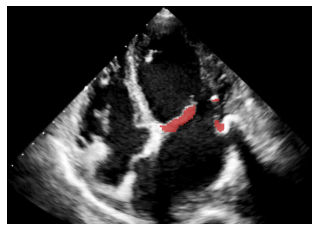

In [ ]:
#@title Run Test data through Bounding Box Regression

def take_only_box(label_in, box_in, shape_in):
  box = convert_back_box(box_in, shape_in)
  label = cv2.resize(label_in, (shape_in[1], shape_in[0]), interpolation=cv2.INTER_NEAREST)
  label = crop_to_box(label, box)
  label = insert_into_bounding_box(label, box, shape_in)
  return label

test_out = []
for j, video in enumerate(test_data):
  #BBR
  X_test_box, X_test_shape = get_test_box(video)
  X_test_box -= data_mean
  X_test_box /= data_std
  test_box = bbr_model.predict(X_test_box)
  #U-Net
  X_test_label, _ = get_test_label(video)
  X_test_label -= data_mean
  X_test_label /= data_std
  labels = unet_model.predict(X_test_label)

  #make full sized
  label_full = []
  for i in range(labels.shape[0]):
    # box = mean_box(test_box)
    label_full.append(take_only_box(labels[i], test_box[i], X_test_shape[i]) > 0.5)

  entry = dict()
  entry['name'] = video['name']
  entry['prediction'] = np.moveaxis(np.asarray(label_full), 0, -1)
  # entry['X'] = X_test_label
  # entry['shape'] = X_test_shapes
  test_out.append(entry)
  if j == 0:
    vid = np.moveaxis(video['video'], -1, 0)
    marked = add_markings(vid, markings=np.moveaxis(entry['prediction'], -1, 0))
    save_video(marked, name = f'test{j}')
    # idx = 30
    # plt.imshow(cv2.resize(X_test_box[idx], (X_test_shapes[idx][1], X_test_shapes[idx][0]), interpolation=cv2.INTER_NEAREST))
    # plt.show()
    # plt.imshow(X_test_label[idx])
    # plt.show()
    # plt.imshow(labels[idx][:,:, 0])
    # plt.show()
    # plt.imshow(insert_into_bounding_box(np.ones((100,100)), convert_back_box(box,X_test_shapes[idx]), X_test_shapes[idx]))
    # plt.show()
    # plt.imshow(entry['prediction'][idx])
    # plt.show()



In [ ]:
#@title Output Results
def untransform(output_image, original_shape):
  w, h = original_shape
  output_image = cv2.resize(output_image, (h, w), interpolation=cv2.INTER_NEAREST)
  return output_image.astype(bool)

def save_zipped_pickle(obj, filename):  # obj are the predictions provided as a list of dictionaries.
  with gzip.open(filename, 'wb') as f:
    pickle.dump(obj, f, 2)

for t in test_out[:4]:
  print(t.keys())
  print(t['prediction'].shape)
print(f"submission_arr: {test_out}")
save_zipped_pickle(test_out, PATH + "submission.pkl")

dict_keys(['name', 'prediction'])
(586, 821, 103)
dict_keys(['name', 'prediction'])
(587, 791, 52)
dict_keys(['name', 'prediction'])
(583, 777, 69)
dict_keys(['name', 'prediction'])
(582, 851, 61)
submission_arr: [{'name': 'E9AHVWGBUF', 'prediction': array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., 